# Simple Triplane introduction

This is a simple introduction into the Triplanes. Triplanes build on top of the idea of NeRFs and are an extension of TensoRF (https://apchenstu.github.io/TensoRF/). 

## (Very) Brief Introduction to NeRFs

Neural Radiance Fields (NeRF) have been introduced in ["NeRF: Representing Scenes as Neural Radiance Fields for View Synthesis"](https://arxiv.org/abs/2003.08934) by Mildenhall et al. with many follow-up works. The idea is to represent a 3D scene as a continuous function that maps a 3D point to a color and density. The color and density are then used to render the scene from a given viewpoint. The function is trained on a set of images with known camera poses and intrinsics. The general concept of Neural Radiance Fields can be visualized by the following image (from the original NeRF paper):

![NeRF](assets/images/nerf.png)

**Input:** spatial location (x,y,x) and viewing direction (θ,ϕ)

**Output:** color intensities c=(r,g,b) and its volume density σ

The (probability) volume density indicates how much radiance (or luminance) is accumulated by a ray passing through (*x*,*y*,*z*) and is a measure of the “effect” this point has on the overall scene. Intuitively, the probability volume density provides the likelihood that the predicted color value should be taken into account.

**Training:** We use the ground truth images to formulate a rendering loss. We (differentiable) map the density and color to the 2D images using volume rendering. 

1. **Generate a sampled set of 3D points** by marching camera rays through the scene.
2. **Produce an output set of densities and colors** by inputting your sampled points with their corresponding 2D viewing directions into the neural network.
3. **Accumulate your densities and colors into a 2D image** by using classical volume rendering techniques.
4. Estimate Rendering Loss based on the errors between each observed image and all corresponding views rendered from the representation  
5. Optimize the Neural Network using gradient descent 

**Volume rendering:** Volume rendering enables you to create a 2D projection of a 3D discretely sampled scene. For a given camera position, a volume rendering algorithm obtains the RGB values for every voxels in the space through which rays from the camera are casted. The RGB color is recorded in the corresponding pixel of the 2D image. This mapping is done by integrating the rays volume densities and colors dependent on the positions the ray traveled over the simulated time. Hence, in the image the dots are different instances in time where we sample the color and density of each of these rays. An in depth introduction to volume rendering can be found in the [Creating a Volumetric Ray Marcher](https://shaderbits.com/blog/creating-volumetric-ray-marcher) blog post, where i found the following image:

![Volume Rendering](assets/images/ray-marching.png)

Another introduction to volume rendering as part of a lecture in [Interactive Computer Graphics](https://graphics.cs.utah.edu/courses/cs6610/spring2021/) from the University of Utah can be found on [Youtube](https://www.youtube.com/watch?v=y4KdxaMC69w&list=PLplnkTzzqsZS3R5DjmCQsqupu43oS9CFN&index=25).

View Synthesis: Ca be thought of the opposite of volume rendering. We create a 3D view from a series of 2D images. 

A nice introduction to NeRFs can be found in [How Neural Radiance Fields (NeRF) and Instant Neural Graphics Primitives work](https://theaisummer.com/nerf/).

## TensoRF

The website [TensoRF](https://apchenstu.github.io/TensoRF/) and the paper [TensoRF: Tensorial Radiance Fields](https://arxiv.org/abs/2203.09517) give a good introduction into the concept of TensoRF. TensoRF uses Matrix-Vector Products to represent shapes in an efficient manner. For each Point in space they sample from the matrices and the vectors to estimate the corresponding color and density in order to use a volume renderer to generate the RGB value. The following image (from the website) shows the general concept of TensoRF: 

![TensoRF](assets/images/overview-tensorf.png)

Doing this they optimize the matrizes and vectors much faster than the NeRF optimization and are still pretty parameter efficient:

![TensoRF](assets/images/parameter-efficiency.png)


## Triplanes

Triplanes, where introduced in [Efficient Geometry-aware 3D Generative Adversarial Networks](https://arxiv.org/abs/2112.07945) by Chan et al. and are similar to TensoRF but simpler in order to predict these features using a neural network. The idea is to represent the 3D space as a 3D grid where the 3D feature values are saved in 3 Planes which are reshaped to represent the planes of a cartesian coordinate system. Doing this we can simply sample points using the corresponding values (or using bilinear interpolation to sample positions more precisely). The triplane features are estimated for each shape. To cool thing is that the these features can be efficiently estimated by a neural network since it they are like images where the image-channels correspond to the planes which only have to be reshaped:

![Triplanes](assets/images/triplane-overview.png)

Each plane can also save more channels to be able to represent more information by having several features for each position. A neural network is used to predict the density and color values based on the summed up plane features. The parameters of the fully connected neural network are trained for all shapes und stay the same (frozen) during inference. 

Extension to this is K-Planes to include things like Movement: https://sarafridov.github.io/K-Planes/, which is also implemented in nerfstudio: https://docs.nerf.studio/nerfology/methods/kplanes.html

## Summary

The authors of [Efficient Geometry-aware 3D Generative Adversarial Networks](https://arxiv.org/abs/2112.07945) show a great comparison for different representations: 

![Comparison](assets/images/comparison.png)

# Learning one set of Triplane parameters for one 3D shape using OpenLRM methods
While Triplanes are originally used to be predicted by a neural network like it is done in OpenLRM, I thought it could be nice introduction to the concept of triplanes to use one set of triplane parameters and optimize it to represent one shape, similar to the idea of NeRFs. Hence, we will use only one 3D shape with rendered images from this shape to optimize one specific set of triplane parameters and a small decoder neural network. In this sense we are overfitting the parameters to only visualize one shape. This is similar to training NeRFs but using the triplane and decoder parameters instead of "only" using a neural network to represent the shape. 

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from openlrm.datasets import MixerDataset

### Load the dataset
Load a simple sample datapoint using the Objaverse Dataset and mixer.py implementations. Which files are loaded is defined in './train.json' and './val.json' based on the objaverse uids. 

For this example I included only one shape. I added the uid of the same shape 8 times in both the train and val set so that we can use the same train loader as the whole LRM model but overfit to this specific shape using a batch size of up to 8.  

In [2]:
batch_size = 1
use_gpu = True

if use_gpu:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    torch.set_float32_matmul_precision('high')
else:
    device = torch.device("cpu")

In [3]:
train_dataset = MixerDataset(
    split="train",
    subsets=[{'name': 'objaverse', 'root_dirs': ['./views/'], 'meta_path': {
        'train': './train.json', 'val': './val.json'}, 'sample_rate': 1.0}],  
    sample_side_views=3,  
    render_image_res_low=64,  # 64
    render_image_res_high=128,  # 192
    render_region_size=64,  # 64
    source_image_res=128,  # 224
    normalize_camera=True,  # true
    normed_dist_to_center='auto',  # auto
)

# build data loader
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    drop_last=True,
    num_workers=4, 
    pin_memory=True,
    persistent_workers=True,
)


### Visualize our sample datapoint

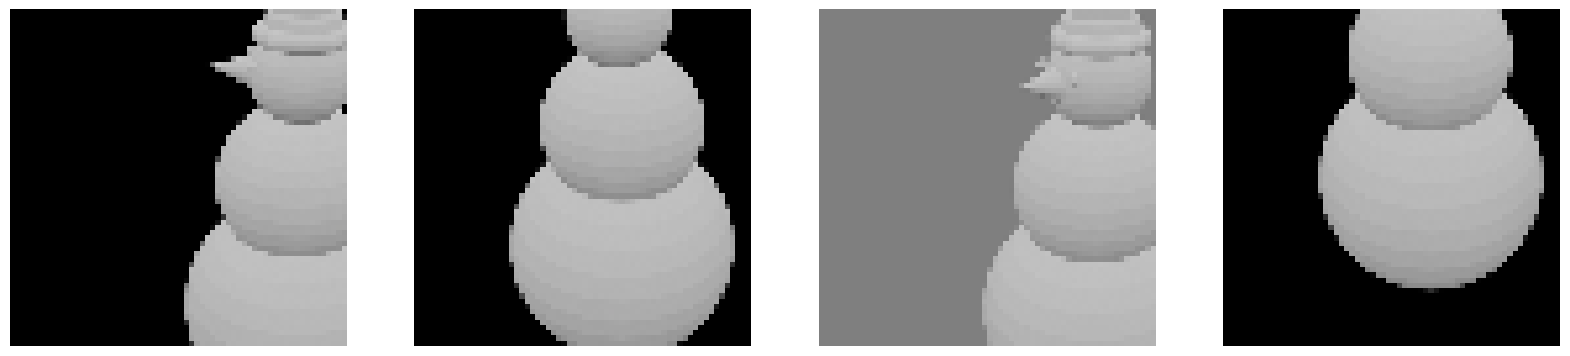

In [4]:
# Sample from the data loader
data_point = next(iter(train_loader))

fig, axs = plt.subplots(1, 4, figsize=(20, 5))
for i in range(4):
    axs[i].imshow(np.transpose(
        data_point['render_image'][0, i].numpy(), (1, 2, 0)))
    axs[i].axis('off')

plt.show()

## Initialize our triplane variables

First let's define the amount of parameters for each dimensions of our triplane. 

In [6]:
# plane Dimension: (N, 3, D', H', W')
# Here D is the amount of channels each dimension in the triplane has and H and W are the height and width of the triplane. N is the batch size and 3 is for the 3 planes in the triplane.
n_planes = 3 # 3: number of planes in the triplane
triplane_dim = 32 # D': depth of the triplane 
batch_dimension = 1 # N: is the batch size - but we will set the batch size in the training loop since we want to use the same parameter for all batch dimensions in the triplane
depth = triplane_dim # D': depth of the triplane
height = 64  # H': height of the triplane
width = 64  # W': width of the triplane

In [7]:
# initialize the triplane features with random values
planes = torch.randn(batch_dimension, n_planes, depth,
                     height, width, requires_grad=True)

In [8]:
# extend the planes variable to the batch size using the same parameter for all batch dimensions
planes_batch = planes.expand(batch_size, -1, -1, -1, -1).to(device)
planes_batch.size()

torch.Size([1, 3, 32, 64, 64])

## Initialize the triplane decoder neural network and synthesizer

The triplane synthesizer model is used to generate images based on the triplane we pass it using a differentiable renderer to generate the image.

It uses a small decoder neural network which will be trained to generate color and density values. These values are passed to the differentiable renderer to generate the image.


In [9]:
from openlrm.models.rendering.synthesizer import TriplaneSynthesizer, OSGDecoder

In [10]:
# n_features: int, hidden_dim: int = 64, num_layers: int = 4, activation: nn.Module = nn.ReLU
hidden_dim = 64
num_layers = 3
decoder = OSGDecoder(n_features=triplane_dim,
                     hidden_dim=hidden_dim, 
                     num_layers=num_layers)

In [11]:
rendering_samples_per_ray = 96
synthesizer = TriplaneSynthesizer(
    triplane_dim=triplane_dim, samples_per_ray=rendering_samples_per_ray, decoder_model=decoder)

In [12]:
synthesizer.decoder.to(device)

OSGDecoder(
  (net): Sequential(
    (0): Linear(in_features=96, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=4, bias=True)
  )
)

## Taking a look at the TriplaneSynthesizer

Let's disect the forward method of the TriplaneSynthesizer to understand how it works. First we will load a data point:

In [13]:
data_point = next(iter(train_loader))
cameras = data_point['render_camera'].to(device)
render_image = data_point['render_image'].to(device)
anchors = data_point['render_anchors'].to(device)
resolutions = data_point['render_full_resolutions'].to(device)
bg_colors = data_point['render_bg_colors'].to(device)
region_size=64 # Shape of the region to render -> 64x64

print(f"cameras shape: {cameras.shape}")
N, M = cameras.shape[:2]
print(f"Batch size: {N}")
print(f"Number of side views: {M}")

cameras shape: torch.Size([1, 4, 25])
Batch size: 1
Number of side views: 4


The forward method looks like this:

```python
def forward(self, planes, cameras, anchors, resolutions, bg_colors, region_size: int):
        # planes: (N, 3, D', H', W')
        # cameras: (N, M, D_cam)
        # anchors: (N, M, 2)
        # resolutions: (N, M, 1)
        # bg_colors: (N, M, 1)
        # region_size: int
        assert planes.shape[0] == cameras.shape[0], "Batch size mismatch for planes and cameras"
        assert planes.shape[0] == anchors.shape[0], "Batch size mismatch for planes and anchors"
        assert cameras.shape[1] == anchors.shape[1], "Number of views mismatch for cameras and anchors"
        N, M = cameras.shape[:2]
        
        cam2world_matrix = cameras[..., :16].view(N, M, 4, 4)
        intrinsics = cameras[..., 16:25].view(N, M, 3, 3)

        # Create a batch of rays for volume rendering
        ray_origins, ray_directions = self.ray_sampler(
            cam2world_matrix=cam2world_matrix.reshape(-1, 4, 4),
            intrinsics=intrinsics.reshape(-1, 3, 3),
            resolutions=resolutions.reshape(-1, 1),
            anchors=anchors.reshape(-1, 2),
            region_size=region_size,
        )
        assert N*M == ray_origins.shape[0], "Batch size mismatch for ray_origins"
        assert ray_origins.dim() == 3, "ray_origins should be 3-dimensional"

        # Perform volume rendering
        rgb_samples, depth_samples, weights_samples = self.renderer(
            planes.repeat_interleave(M, dim=0), self.decoder, ray_origins, ray_directions, self.rendering_kwargs,
            bg_colors=bg_colors.reshape(-1, 1),
        )

        # Reshape into 'raw' neural-rendered image
        Himg = Wimg = region_size
        rgb_images = rgb_samples.permute(0, 2, 1).reshape(N, M, rgb_samples.shape[-1], Himg, Wimg).contiguous()
        depth_images = depth_samples.permute(0, 2, 1).reshape(N, M, 1, Himg, Wimg)
        weight_images = weights_samples.permute(0, 2, 1).reshape(N, M, 1, Himg, Wimg)

        return {
            'images_rgb': rgb_images,
            'images_depth': depth_images,
            'images_weight': weight_images,
        }
```

We will skip the shape assertions and start with reshaping the camera parameters. 

In [14]:
cam2world_matrix = cameras[..., :16].view(N, M, 4, 4)
print(f"cam2world_matrix: {cam2world_matrix.shape}")

intrinsics = cameras[..., 16:25].view(N, M, 3, 3)
print(f"intrinsics: {intrinsics.shape}")

cam2world_matrix: torch.Size([1, 4, 4, 4])
intrinsics: torch.Size([1, 4, 3, 3])


Next we take a look at the ray sampler step. The object `self.ray_sampler` is also a `torch.nn.Module` from the class `RaySampler` in `models.renderin.utils.ray_sampler.py`. It is a module that takes in camera matrices and resolution and batches of rays. 

It returns the ray origins and directions, where the amount of rays for each image to render corresponds to the region size squared. For a region size of 64 it will be 4096 since we will need 64x64 rays for a 64x64 image.

Input:
```
cam2world_matrix: (N, 4, 4)
intrinsics: (N, 3, 3)
resolutions: (N, 1)
anchors: (N, 2)
region_size: int
```

Output:
```
ray_origins: (N, region_size**2, 3)
ray_dirs: (N, region_size**2, 2)
```

In [15]:
ray_origins, ray_directions = synthesizer.ray_sampler(
    cam2world_matrix=cam2world_matrix.reshape(-1, 4, 4),
    intrinsics=intrinsics.reshape(-1, 3, 3),
    resolutions=resolutions.reshape(-1, 1),
    anchors=anchors.reshape(-1, 2),
    region_size=region_size,
    )
print(f"ray_origins: {ray_origins.shape} first dimension has to be the same size as N*M: {N*M}")
print(f"ray_directions: {ray_directions.shape}")

ray_origins: torch.Size([4, 4096, 3]) first dimension has to be the same size as N*M: 4
ray_directions: torch.Size([4, 4096, 3])


After sampling the rays we pass the rays to the renderer for volume rendering. 

The renderer is a `torch.nn.Module` from the class `ImportanceRenderer` in `models.rendering.utils.renderer.py`. It is a modified Version from TensoRF: https://github.com/apchenstu/TensoRF/blob/main/models/tensorBase.py#L277. 

It takes in the planes, the decoder neural network which are used to generate the color and density values for the volume rendering. For the volume rendering we also need the ray origins and directions which we got from the ray sampler. Lastly it also uses some rendering kwargs (see below what arguments) and background colors. 

It first performs a coarse pass to get the initial color and density values. Then it performs a fine pass to get the final color and density values. In the coarse pass the rays are used to determine sample coordinates which are then used to sample the features from the planes (triplane features) which are then passed to the decoder neural network to get the color and density values. These are processed by a ray marcher to estimate weights for estimating finer depths which are used to generate finer color and density values in the fine pass step. Lastly the ray marcher is used to take all color, density and depths to generate the final image. 

The renderer returns the rendered images, depth and weights.

In [16]:
synthesizer.rendering_kwargs

{'ray_start': 'auto',
 'ray_end': 'auto',
 'box_warp': 2.0,
 'white_back': False,
 'disparity_space_sampling': False,
 'clamp_mode': 'softplus',
 'sampler_bbox_min': -1.0,
 'sampler_bbox_max': 1.0,
 'depth_resolution': 48,
 'depth_resolution_importance': 48}

In [17]:
bg_colors.reshape(-1, 1)

tensor([[0.0000],
        [0.5000],
        [1.0000],
        [0.0000]], device='cuda:0')

In [18]:
rgb_samples, depth_samples, weights_samples = synthesizer.renderer(
    planes_batch.repeat_interleave(M, dim=0),
    synthesizer.decoder,
    ray_origins, 
    ray_directions, 
    synthesizer.rendering_kwargs,
    bg_colors=bg_colors.reshape(-1, 1),
    )
print(f"rgb_samples: {rgb_samples.shape}")
print(f"depth_samples: {depth_samples.shape}")
print(f"weights_samples: {weights_samples.shape}")

rgb_samples: torch.Size([4, 4096, 3])
depth_samples: torch.Size([4, 4096, 1])
weights_samples: torch.Size([4, 4096, 1])


In [19]:
# Reshape into 'raw' neural-rendered image
Himg = Wimg = region_size
rgb_images = rgb_samples.permute(0, 2, 1).reshape(N, M, rgb_samples.shape[-1], Himg, Wimg).contiguous()
depth_images = depth_samples.permute(0, 2, 1).reshape(N, M, 1, Himg, Wimg)
weight_images = weights_samples.permute(0, 2, 1).reshape(N, M, 1, Himg, Wimg)
print(f"rgb_images: {rgb_images.shape}")
print(f"depth_images: {depth_images.shape}")
print(f"weight_images: {weight_images.shape}")

rgb_images: torch.Size([1, 4, 3, 64, 64])
depth_images: torch.Size([1, 4, 1, 64, 64])
weight_images: torch.Size([1, 4, 1, 64, 64])


### Let's visualize the rendered image using the initial triplane parameters

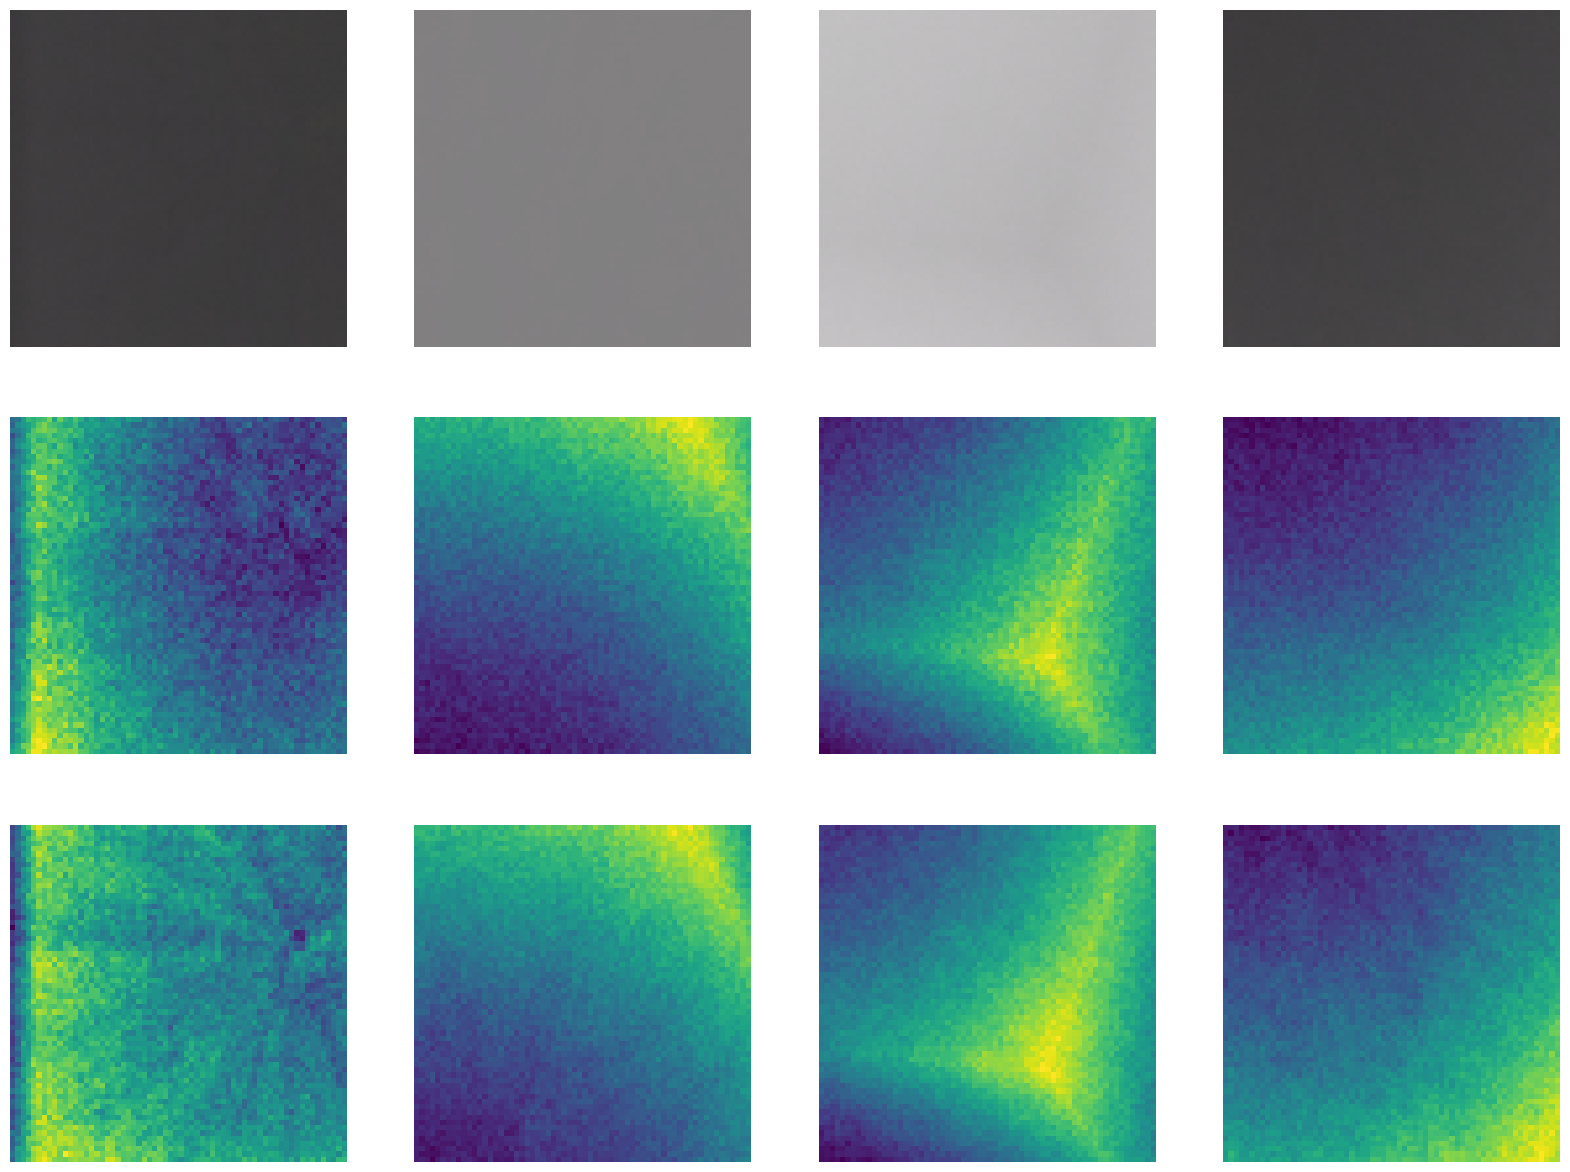

In [20]:
fig, axs = plt.subplots(3, 4, figsize=(20, 15))
for i in range(4):
    axs[0, i].imshow(np.transpose(
        rgb_images[0, i].detach().cpu().numpy(), (1, 2, 0)))
    axs[0, i].axis('off')
    axs[1, i].imshow(np.transpose(
        depth_images[0, i].detach().cpu().numpy(), (1, 2, 0)))
    axs[1, i].axis('off')
    axs[2, i].imshow(np.transpose(
        weight_images[0, i].detach().cpu().numpy(), (1, 2, 0)))
    axs[2, i].axis('off')
plt.show()

## Initialize our  optimizer

We will pass the triplane variables and the decoder parameters to the optimizer since both have to be optimized together on the same goal.

In [21]:
# get the parameter from the synthesizer.decoder to optimize them
decoder_parameter = synthesizer.decoder.parameters()

# add the decoder_parameter and the planes parameter to the optimizer
optimizer = torch.optim.Adam(list(decoder_parameter) + [planes], lr=1e-3)

## Define a forward pass and loss calculation

For now we will stick with a simple pixel wise mean squared error loss. We will also define a forward pass function which will take the triplane parameter and return the rendered image using the decoder neural network.

In [22]:
def forward_loss_local_step(data_point):
    render_camera = data_point['render_camera'].to(device)
    render_image = data_point['render_image'].to(device)
    render_anchors = data_point['render_anchors'].to(device)
    render_full_resolutions = data_point['render_full_resolutions'].to(device)
    render_bg_colors = data_point['render_bg_colors'].to(device)

    # render target views
    render_results = synthesizer(planes=planes_batch,
                                 cameras=render_camera,
                                 anchors=render_anchors,
                                 resolutions=render_full_resolutions,
                                 bg_colors=render_bg_colors,
                                 region_size=64)

    # compute loss
    loss = 0.
    loss_pixel = torch.nn.functional.mse_loss(
        render_results['images_rgb'], render_image)
    loss += loss_pixel 

    return render_results, loss

## Train the model

This is a simple training loop where we will optimize the triplane parameters and the decoder parameters to minimize the loss function. 

In [23]:
epopchs = 200 # The model seems to learn the rough shape within 200 epochs - it gets better with more training. 
for epoch in range(epopchs):
    for data in train_loader:
        render_results, loss = forward_loss_local_step(data)
        optimizer.zero_grad()
        loss.backward()
        print(f"mean of planes.grad: {planes.grad.mean()}")
        optimizer.step()
        print(f"Loss: {loss.item()}")

mean of planes.grad: -7.171855886944911e-10
Loss: 0.043675199151039124
mean of planes.grad: -1.21546894771285e-09
Loss: 0.04856458306312561
mean of planes.grad: 8.91522064505601e-11
Loss: 0.08231401443481445
mean of planes.grad: -7.795967760237943e-10
Loss: 0.05839826911687851
mean of planes.grad: -5.535399361100701e-10
Loss: 0.05220701918005943
mean of planes.grad: -6.545122777090739e-10
Loss: 0.03262217715382576
mean of planes.grad: -7.521006595290203e-10
Loss: 0.08237287402153015
mean of planes.grad: -3.2041480579891868e-09
Loss: 0.0397917777299881
mean of planes.grad: -2.442346547226748e-09
Loss: 0.04699849337339401
mean of planes.grad: -5.085093235379645e-09
Loss: 0.04977750778198242
mean of planes.grad: -5.654737567084567e-09
Loss: 0.026741161942481995
mean of planes.grad: -3.0239561965572648e-09
Loss: 0.04119059443473816
mean of planes.grad: -3.1512568110514394e-09
Loss: 0.05975417047739029
mean of planes.grad: -2.990866998509034e-10
Loss: 0.08496519178152084
mean of planes.grad

## Visualize the rendered image after training

Loss: 0.006198793184012175


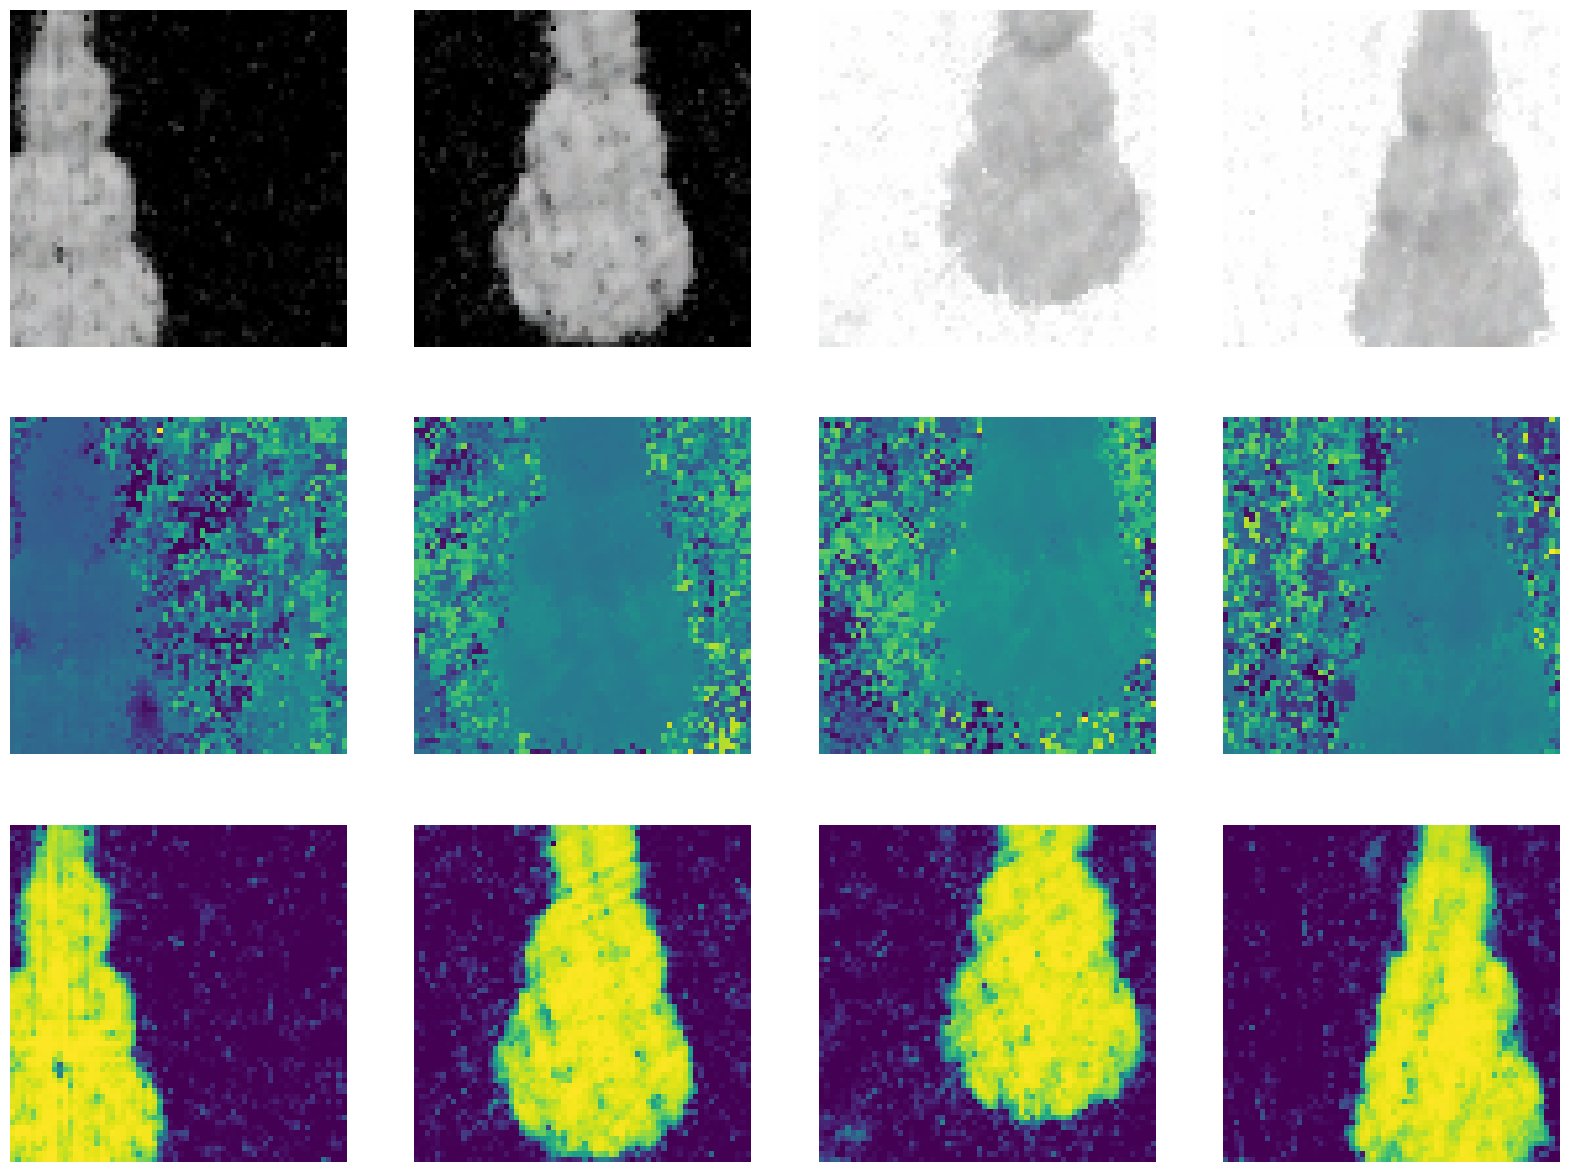

In [26]:
data_point = next(iter(train_loader))
with torch.no_grad():
    render_results, loss = forward_loss_local_step(data_point)
    print(f"Loss: {loss.item()}")
    fig, axs = plt.subplots(3, 4, figsize=(20, 15))
    for i in range(4):
        axs[0, i].imshow(np.transpose(
            render_results['images_rgb'][0, i].detach().cpu().numpy(), (1, 2, 0)))
        axs[0, i].axis('off')
        axs[1, i].imshow(np.transpose(
            render_results['images_depth'][0, i].detach().cpu().numpy(), (1, 2, 0)))
        axs[1, i].axis('off')
        axs[2, i].imshow(np.transpose(
            render_results['images_weight'][0, i].detach().cpu().numpy(), (1, 2, 0)))
        axs[2, i].axis('off')
    plt.show()